In [40]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [41]:
from torchvision import transforms, datasets
from torchvision.utils import save_image

path_training =  "../public/data/train/"
path_test =      "../public/data/val/"

train_transform = transforms.Compose([    
    # transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomGrayscale(p=0.2),            
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


test_transform = transforms.Compose([
    # transforms.ToPILImage(),                           
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [42]:
train_img = datasets.ImageFolder(path_training, transform=train_transform)
test_img = datasets.ImageFolder(path_test, transform=test_transform)

trainloaders = torch.utils.data.DataLoader(train_img, batch_size=8, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=8, shuffle=True)



In [43]:
print("tipe data training                   :",type(train_img))
print("jumlah data training                 :",len(train_img))
print("jumlah data test                     :",len(train_img))
print("kelas data_training                  :",train_img.classes)

tipe data training                   : <class 'torchvision.datasets.folder.ImageFolder'>
jumlah data training                 : 348
jumlah data test                     : 348
kelas data_training                  : ['2', '3', '4', '5', '6', '7', '9']


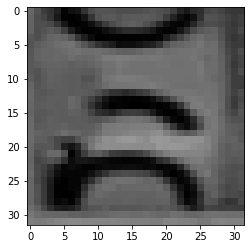

5


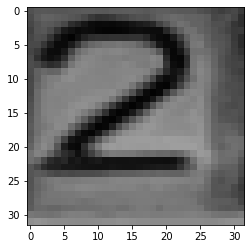

2


In [44]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5],)
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

for image, label in trainloaders:
    for i in range(0,2):
        imshow((image[i], label[i]))
    break

In [49]:
#{Model Deep Learning}
import torch 
import torch.nn as nn

#{klasifikasi menggunakan LeNet5}
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.conv_layer_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.conv_layer_3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.linear_layer_1 = nn.Linear(in_features=120, out_features=84)
        self.linear_layer_2 = nn.Linear(in_features=84, out_features=7)
        self.pooling_layer = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.tanh(x)
        x = self.pooling_layer(x)
        
        x = self.conv_layer_2(x)
        x = self.tanh(x)
        x = self.pooling_layer(x)
        
        x = self.conv_layer_3(x)
        x = self.tanh(x)
        
        x = x.reshape((x.shape[0], -1))
        x = self.linear_layer_1(x)
        x = self.tanh(x)
        
        x = self.linear_layer_2(x)
        
        return x

model = LeNet()
model.to(torch.device('cuda'))

LeNet(
  (conv_layer_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer_3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear_layer_1): Linear(in_features=120, out_features=84, bias=True)
  (linear_layer_2): Linear(in_features=84, out_features=7, bias=True)
  (pooling_layer): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (tanh): Tanh()
)

In [50]:
#{Deklarasi Criterion dan Optimizer}
# criterion = nn.NLLLoss(reduction="sum")
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [52]:
#{Deklarasi Training dan Validasi}
import numpy as np

def metrics_batch(target, output):
    # obtain output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, xb, yb,yb_h, opt=None):
    
    # obtain loss
    loss = loss_func(yb_h, yb)
    
    # obtain performance metric
    metric_b = metrics_batch(yb,yb_h)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), metric_b


def loss_epoch(model,loss_func,dataset_dl,opt=None):
    loss=0.0
    metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        
        # obtain model output
        yb_h=model(xb)

        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
    loss/=len_data
    metric/=len_data
    return loss, metric



def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)
        
            
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        
        accuracy=100*val_metric

        print("epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f" %(epoch, train_loss,val_loss,accuracy))



In [53]:
num_epochs=100
train_val(num_epochs, model, loss_function, optimizer, trainloaders, testloaders)

epoch: 0, train loss: 0.163721, val loss: 0.111060, accuracy: 78.57
epoch: 1, train loss: 0.061975, val loss: 0.062132, accuracy: 84.52
epoch: 2, train loss: 0.026133, val loss: 0.059130, accuracy: 88.10
epoch: 3, train loss: 0.013256, val loss: 0.042702, accuracy: 92.86
epoch: 4, train loss: 0.008158, val loss: 0.050322, accuracy: 94.05
epoch: 5, train loss: 0.008205, val loss: 0.036026, accuracy: 96.43
epoch: 6, train loss: 0.003543, val loss: 0.036031, accuracy: 92.86
epoch: 7, train loss: 0.002355, val loss: 0.035030, accuracy: 96.43
epoch: 8, train loss: 0.001586, val loss: 0.033295, accuracy: 94.05
epoch: 9, train loss: 0.000988, val loss: 0.034545, accuracy: 95.24
epoch: 10, train loss: 0.000702, val loss: 0.036760, accuracy: 94.05
epoch: 11, train loss: 0.000630, val loss: 0.034717, accuracy: 95.24
epoch: 12, train loss: 0.000522, val loss: 0.037769, accuracy: 95.24
epoch: 13, train loss: 0.000492, val loss: 0.035491, accuracy: 95.24
epoch: 14, train loss: 0.000384, val loss: 0

<class 'numpy.ndarray'> (42, 27, 3)


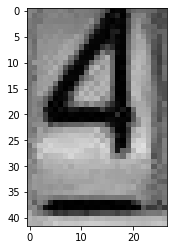

In [33]:
import cv2
from PIL import Image
imagepath = '../public/data/val/4/4.11.jpg'
image_test = cv2.imread(imagepath)
print(type(image_test), image_test.shape)
image_test=Image.fromarray(image_test)
plt.imshow(image_test)
plt.show()

tensor([[-2.3343, -0.8229,  9.8753, -1.4624, -2.1002, -3.4324, -1.9697]],
       grad_fn=<AddmmBackward>)
PREDICTION: 4


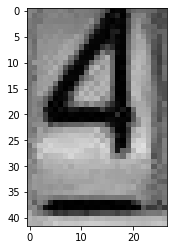

In [34]:
from PIL import Image, ImageDraw
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

plt.imshow(image_test)
plt.show()

In [36]:
path2model="../public/models/model.pt"
torch.save(model,path2model)
_model = LeNet()
_model=torch.load(path2model)

In [38]:
path2weights="../public/weights/weight.pt"
# torch.save(model.state_dict(), path2weights)
_model = LeNet()
# weights=torch.load(path2weights)
_model.load_state_dict(path2weights)
torch.save(model.state_dict(), path2weights)

<All keys matched successfully>

DEPLOYING MODELS

<class 'numpy.ndarray'> (42, 27, 3)


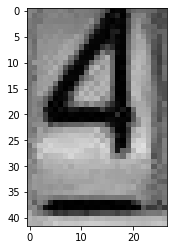

In [39]:
import cv2
image_test = cv2.imread(imagepath)
print(type(image_test), image_test.shape)
image_test=Image.fromarray(image_test)
plt.imshow(image_test)
plt.show()